# This notebook contains the Stacks parameter tests, final scripts used and analyses to identify sex linked markers for the ddRADseq dataset of <i>Rana italica</i> 
## Sample set:

This sample set is a set of unsexed tadpoles, from one family. Samples were collected by Daniele Canestrelli.



In [2]:
%matplotlib inline
from __future__ import division
import os
import Incremental_U as IncU 
import Incremental_C as IncC
import Incremental_Pop_mod as IncPop
import MISC_RAD_tools as MISC
import pprint
import subprocess
from matplotlib import pyplot as plt

In [2]:
%load_ext rpy2.ipython

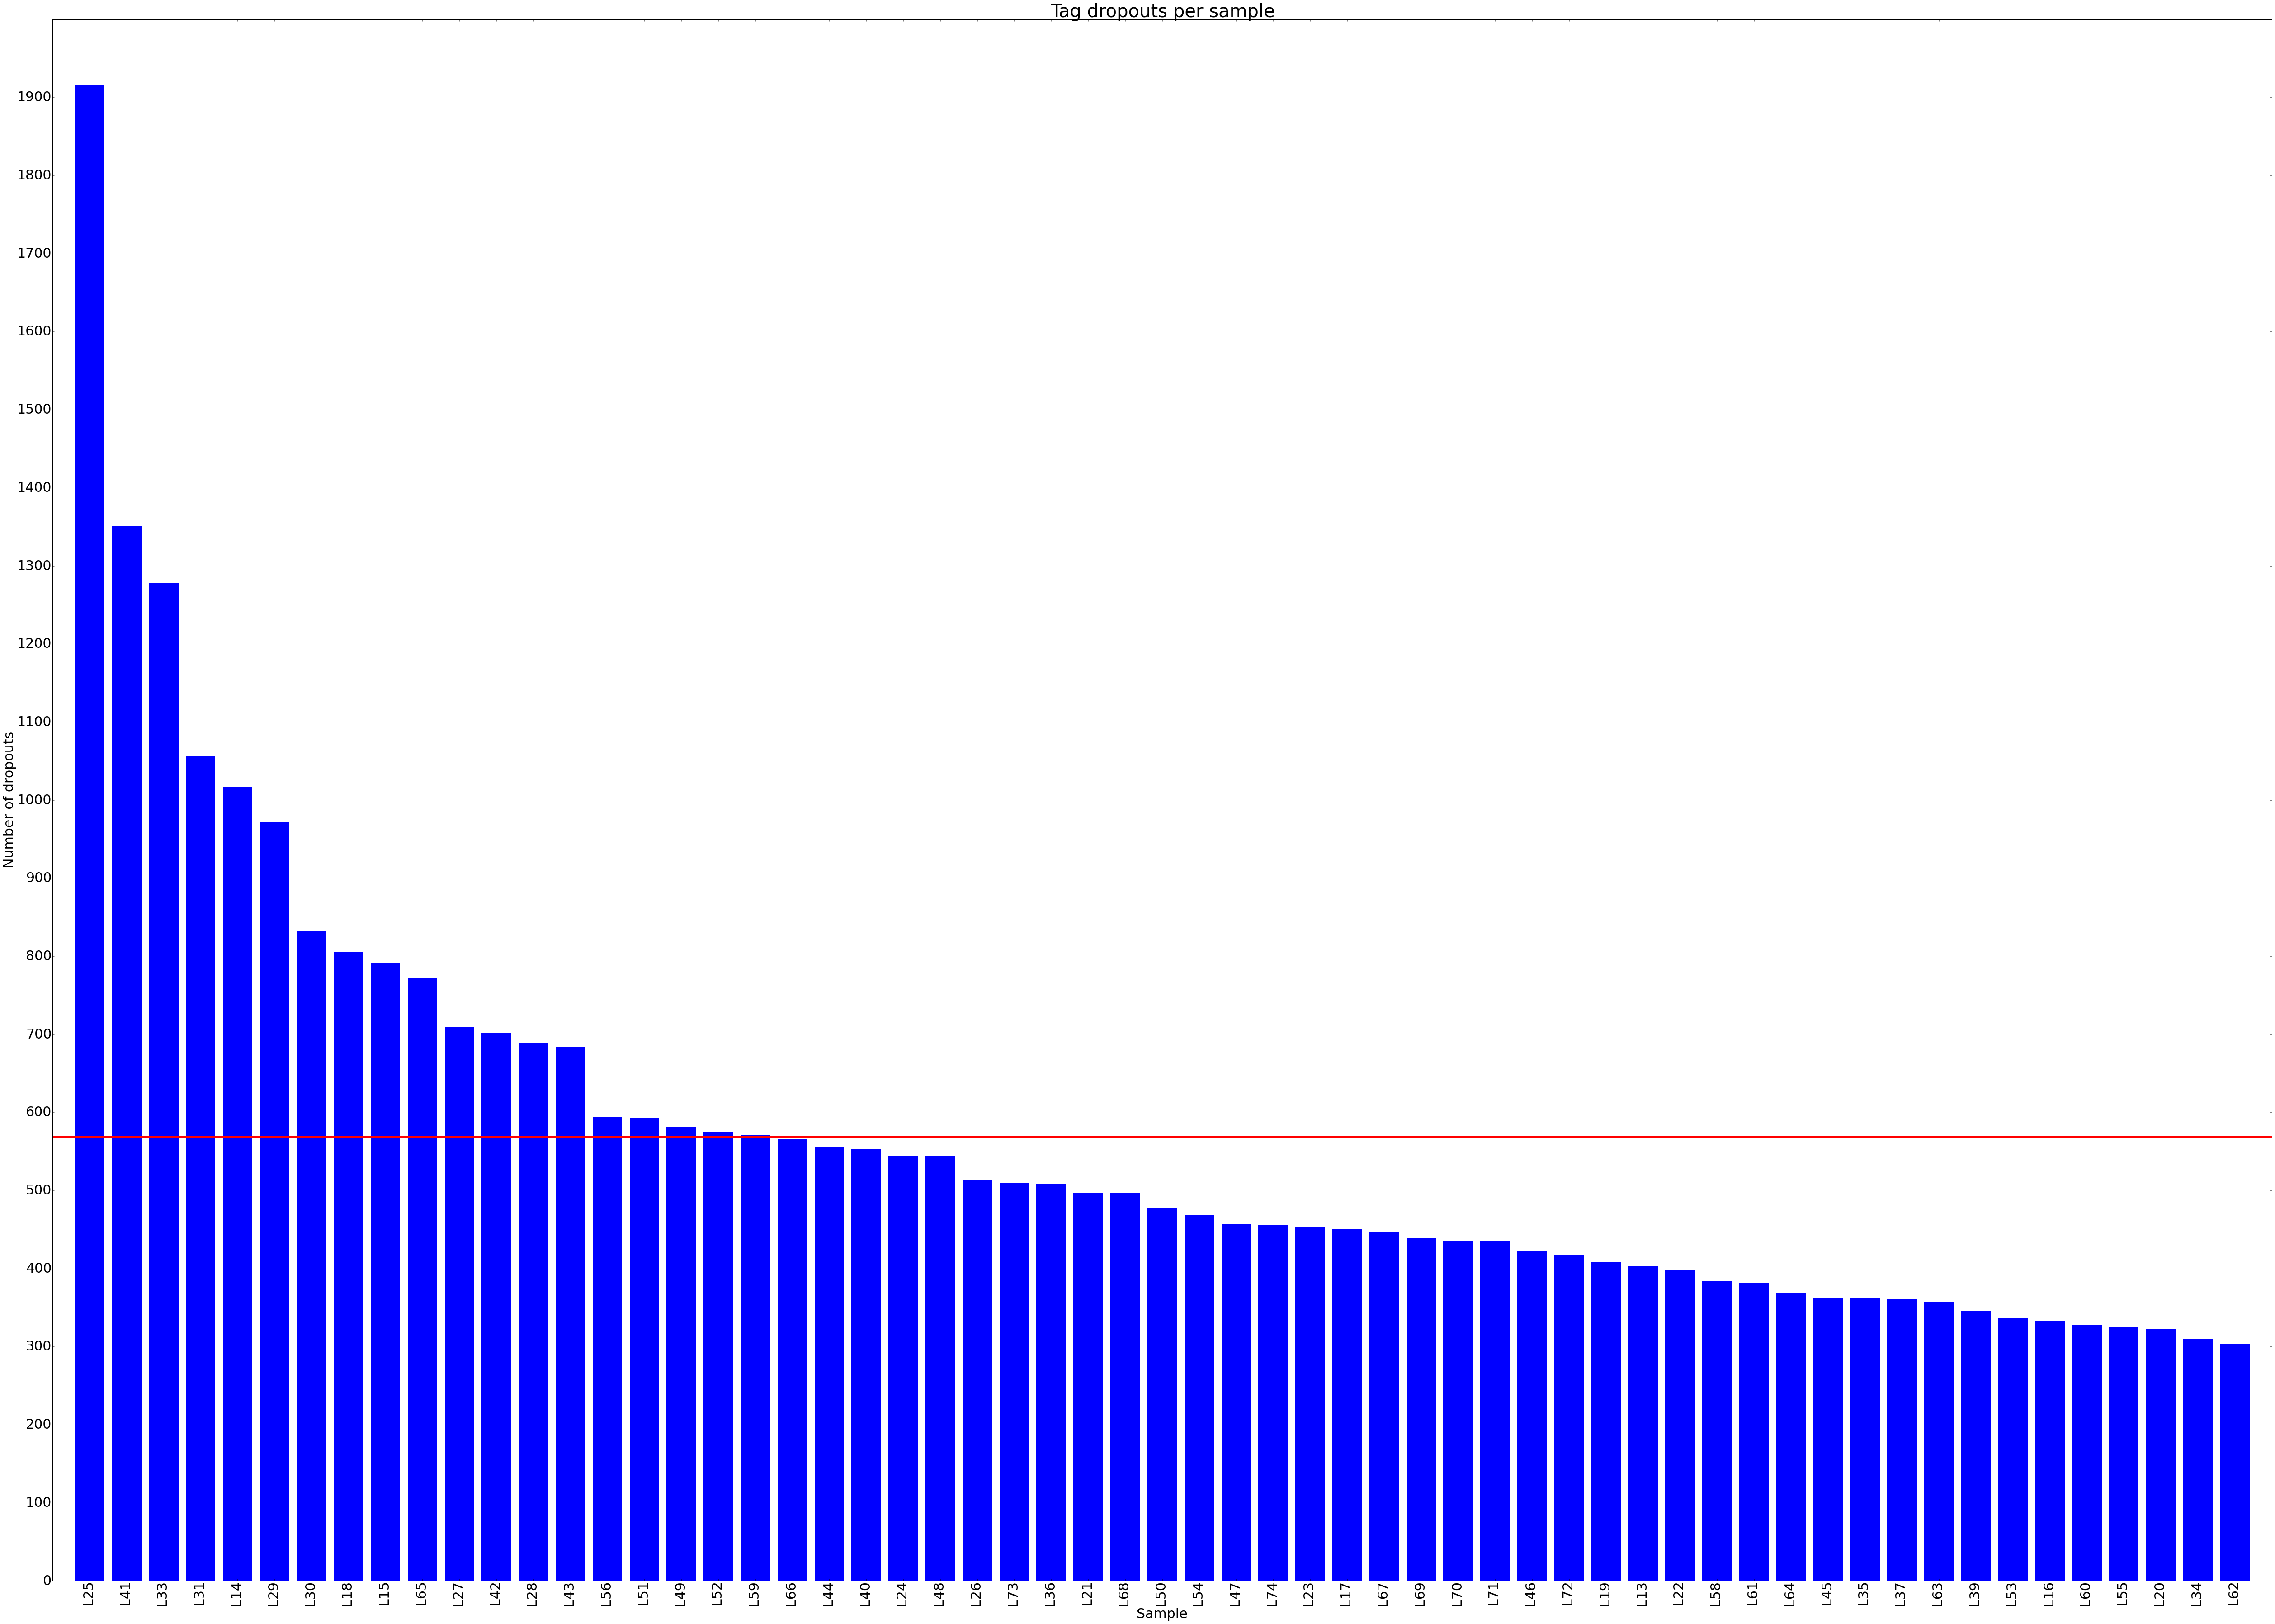

Outputs written to:
/home/djeffrie/Data/RADseq/Ritalica3/Stacks/Tag_dropouts_per_sample.txt
/home/djeffrie/Data/RADseq/Ritalica3/Stacks/Tag_dropouts_per_tag.txt
/home/djeffrie/Data/RADseq/Ritalica3/Stacks/Tag_dropouts_per_sample.pdf
/home/djeffrie/Data/RADseq/Ritalica3/Stacks/Tag_dropouts_per_tag.pdf
/home/djeffrie/Data/RADseq/Ritalica3/Stacks/blacklist.txt


In [3]:
wd = "/home/djeffrie/Data/RADseq/Ritalica3/Stacks"

blacklist = MISC.missing_data_finder("%s/batch_1.vcf" % wd, wd)

So pretty bloody nice really, there are only a few samples with high dropout, shouldn't make much difference at all. 

### Now run a PCA to look at the structure in the data . . . 

In [10]:
%%bash

wd=/home/djeffrie/Data/RADseq/Ritalica3/Stacks/Populations_all  ## just change this line

## All data 
sed 's/_/-/g' $wd/batch_1.vcf > $wd/batch_1_altered_adegenet.vcf

/home/djeffrie/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_altered_adegenet.vcf --recode A --allow-extra-chr -out $wd/batch_1_altered_adegenet_plink


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/Ritalica3/Stacks/Populations_all/batch_1_altered_adegenet_plink.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/Ritalica3/Stacks/Populations_all/batch_1_altered_adegenet_plink
  --recode A
  --vcf /home/djeffrie/Data/RADseq/Ritalica3/Stacks/Populations_all/batch_1_altered_adegenet.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/Ritalica3/Stacks/Populations_all/batch_1_altered_adegenet_plink-temporary.bed
+
/home/djeffrie/Data/RADseq/Ritalica3/Stacks/Populations_all/batch_1_altered_adegenet_plink-temporary.bim
+
/home/djeffrie/Data/RADseq/Ritalica3/Stacks/Populations_all/batch_1_altered_adegenet_plink-temporary.fam
written.
4250 variants loaded from .bim file.
59 people (0 males, 0 females, 59 ambiguous) loaded 

In [11]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.R")

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/Ritalica3/Stacks/Populations_all") 

## All SNPs (about 80,000)
alldata <- read.PLINK('batch_1_altered_adegenet_plink.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 

## Sex information:
sexes <- read.delim("./popmap.txt", header = F)

## Running PCA ---------------------------------------------------------------------------------------

pca1 <- glPca(alldata, parallel = TRUE, n.cores = 6, nf = 5) 



 Reading PLINK raw format into a genlight object... 


 Reading loci information... 

 Reading and converting genotypes... 
.
 Building final object... 

...done.



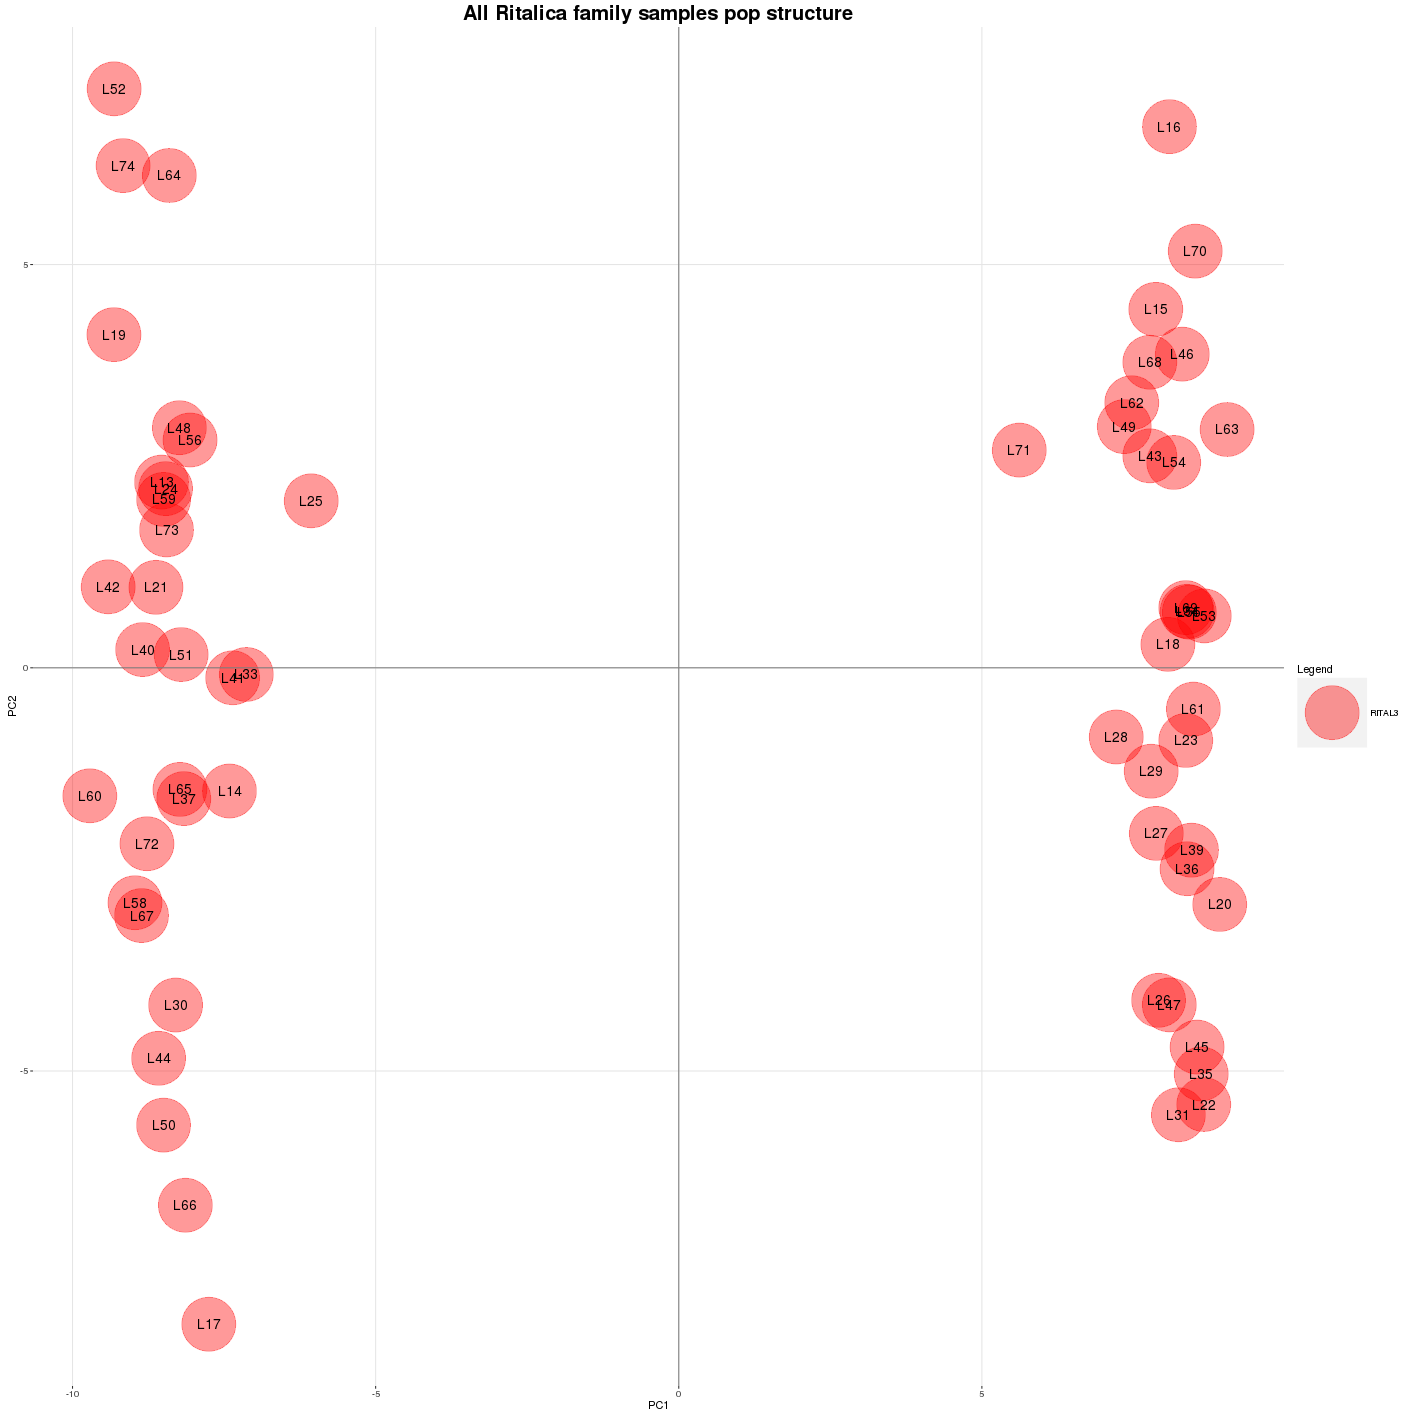

In [12]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.

Sex_sorter(pca1,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plot
           Title = "All Ritalica family samples pop structure", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = rainbow(12), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

Boom, Males and females! Not sure which is which though - making a heatmap to look for the sex which has heterozygous sex linked loci

In [13]:
%%bash

wd=/home/djeffrie/Data/RADseq/Ritalica3/Stacks/Populations_all

sh /home/djeffrie/Dropbox/My_Dropbox_Scripts/Bash/Make_heatmap_input.sh  $wd/batch_1_altered_adegenet_plink.raw  $wd/batch_1_heatmap_input


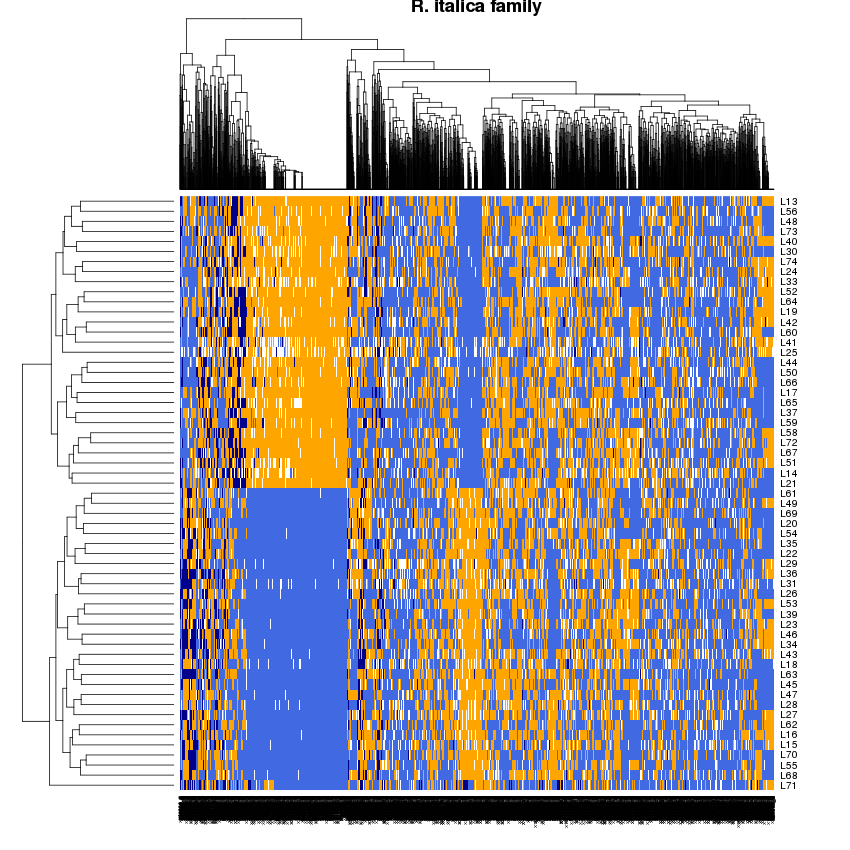

In [14]:
%%R -w 30 -h 30 -u cm

XY_heatmap_data <- read.delim("/home/djeffrie/Data/RADseq/Ritalica3/Stacks/Populations_all/batch_1_heatmap_input.raw", row.names = 1)
XY_heatmap_data_sorted <- XY_heatmap_data[order(row.names(XY_heatmap_data), decreasing = T), ]
XY_heatmap_data_datmat <- as.matrix(XY_heatmap_data_sorted)

heatmap(XY_heatmap_data_datmat, scale='none', col = c("royalblue", "orange", "darkblue"), cexRow = 1, main = "R. italica family")


So the guys on the left in the PCA are the males

So there are some clearly sex linked loci here, showing XY. However, there is a very strange pattern whereby there is a set of loci which also show ZW signal.

I could not have biased the data in anyway - I did not know males and females before this point. Besides, the signal is among loci, not among samples, so any bias would have to be at the locus level. However all samples were processed through stacks in the same way, at the same time. I can therefore think of no technical reason why there might be both signals. 

So the question is, what situation can cause females to always be heterozygous and males to always be homozygous, whilst there still being an XY system in place. 

Unfortunately, we do not know what the phenotypic sex of these offspring would have been.



### Finding sex linked markers

    So now I will assign sexes to individuals based on the PCA above and then look for sex linked markers, should get a fair few I think. 


### Northern Spanish populaitons first (with parents from family)

Number of tags =  4250
Average tag coverage 27.901224327 (+- 24.0352906573 )


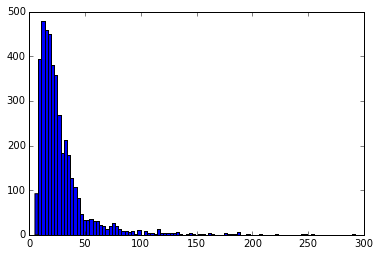

In [1]:
%matplotlib inline
import MISC_RAD_tools as MISC
wd = "/home/djeffrie/Data/RADseq/Ritalica3/Stacks/Populations_all/"
final_vcf = "%s/batch_1.vcf" % wd
MISC.av_tag_cov(final_vcf, "%s/Av_tag_cov.out" % wd)
#MISC.sample_Avcov_from_vcf(final_vcf)

In [3]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Ritalica3/Stacks/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Ritalica3/Stacks/Populations_all/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Ritalica3/Stacks/Sex_ID_info.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 7 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 0.9 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 0.9 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 7 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.




##### Using SNP frequency approach #### 

Number of loci = 4250
Number of samples = 59
Number of loci with too few samples = 573
Number of loci with low MAF = 0
Number of loci with enough data = 3676
Number of putative X linked snps = 621
Number of putative X linked tags = 621
Number of putative Z linked markers = 140
Number of putative Z linked tags = 140


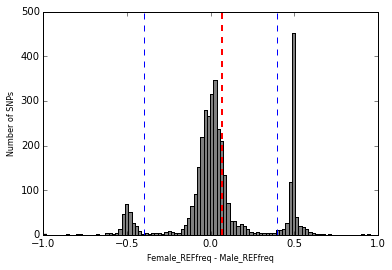


***DONE!***


##### Using SNP heterozygosity approach #####
 
Number of loci = 4250
Number of samples = 59
Number of loci with too few samples = 573
Number of loci with low MAF = 0
Number of loci with enough data = 3676
Number of putative X linked snps = 639
Number of putative X linked tags = 639
Number of putative Z linked markers = 149
Number of putative Z linked tags = 149

 ### DONE! ### 


##### Using Sex specific tag approach ##### 


SUMMARY:
Number of males: 30
Number of males: 29
Number of Putative Y linked tags: 517
Number of Putative W linked tags: 97

 ### DONE! ###

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Ritalica3/Stacks

 ## After merging tags accross methods ## 

Final number of XY tags = 1157
Final number of ZW tags = 249


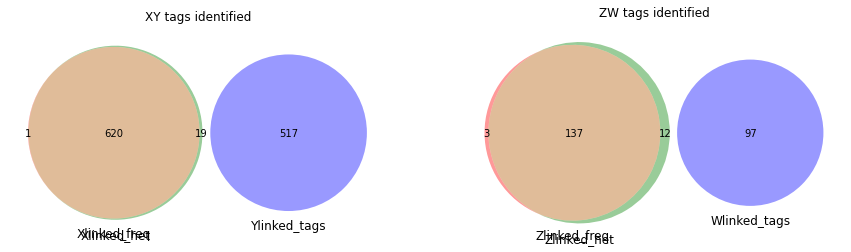

In [4]:
XYset, ZWset = MISC.Super_SLM_finder(Parameter_dict, "111")

So as expected there is a huge number of XY markers, but also a large, confidently assigned number of ZW-looking markers too. . . 

### Does coverage tell us anything?? Hemizygosity for example??

Number of tags =  655
Average tag coverage 23.8541337819 (+- 11.8785075325 )


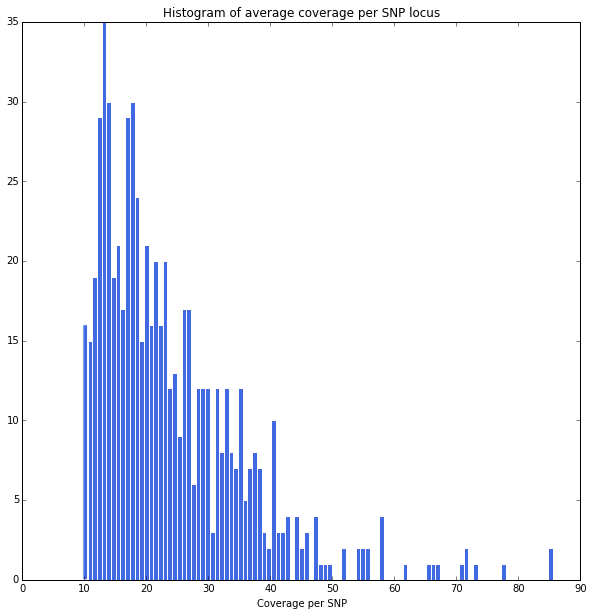

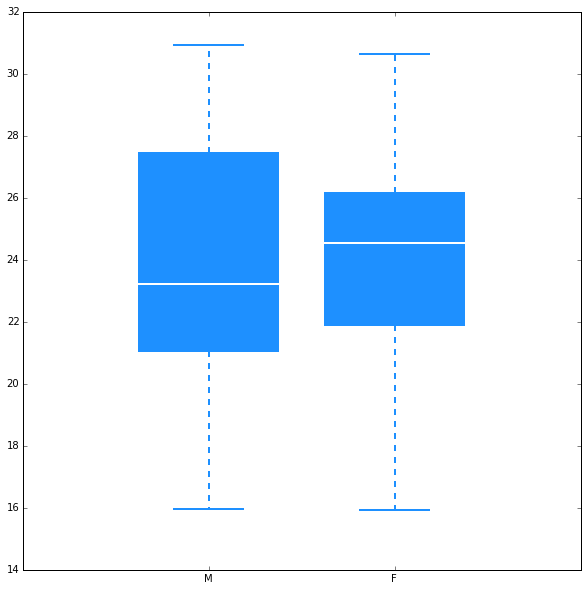

In [97]:
## XY

XYlist = [i.split("_")[0] for i in XYset]

XYraw_means, XYpop_dict = MISC.Super_av_tag_cov("/home/djeffrie/Data/RADseq/Ritalica3/Stacks/Populations_all/batch_1.vcf", \
                                       popmap = "/home/djeffrie/Data/RADseq/Ritalica3/Stacks/Sex_ID_info.txt",\
                                       whitelist = XYlist)

Number of tags =  167
Average tag coverage 30.1649243885 (+- 22.6501654888 )


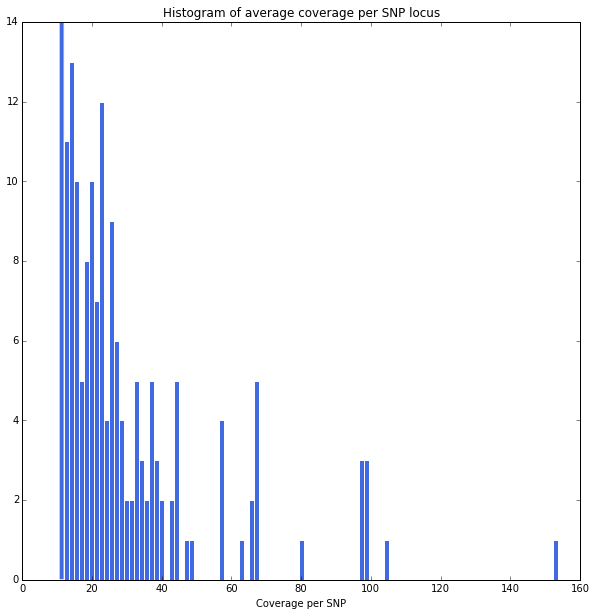

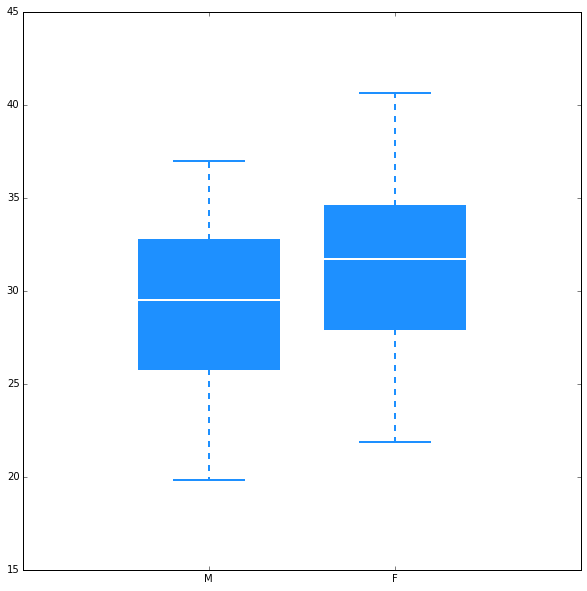

In [98]:
## ZW

ZWlist = [i.split("_")[0] for i in ZWset]

ZWlike_raw_means, ZWlike_pop_dict = MISC.Super_av_tag_cov("/home/djeffrie/Data/RADseq/Ritalica3/Stacks/Populations_all/batch_1.vcf", \
                                       popmap = "/home/djeffrie/Data/RADseq/Ritalica3/Stacks/Sex_ID_info.txt",\
                                       whitelist = ZWlist)

Number of tags =  4250
Average tag coverage 27.901224327 (+- 24.0352906573 )


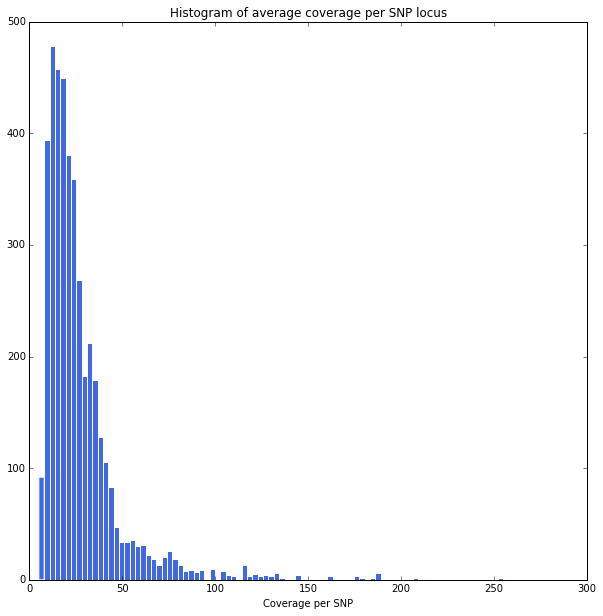

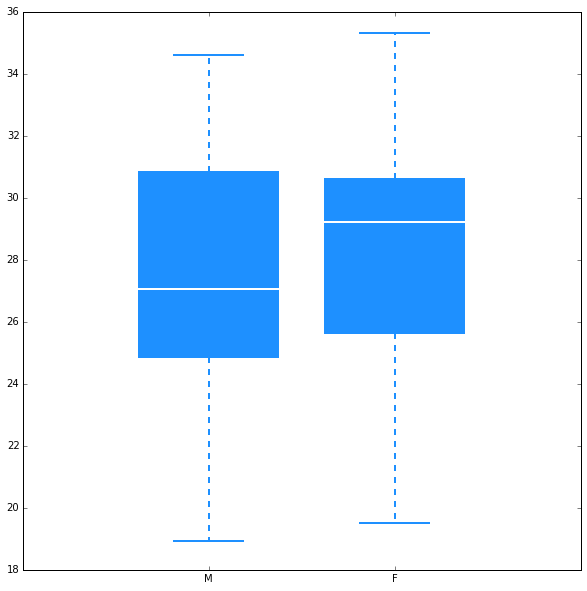

In [99]:
## Autosomal

ZWlist = [i.split("_")[0] for i in ZWset]

Auto_raw_means, Auto_pop_dict = MISC.Super_av_tag_cov("/home/djeffrie/Data/RADseq/Ritalica3/Stacks/Populations_all/batch_1.vcf", \
                                       popmap = "/home/djeffrie/Data/RADseq/Ritalica3/Stacks/Sex_ID_info.txt")

M
F


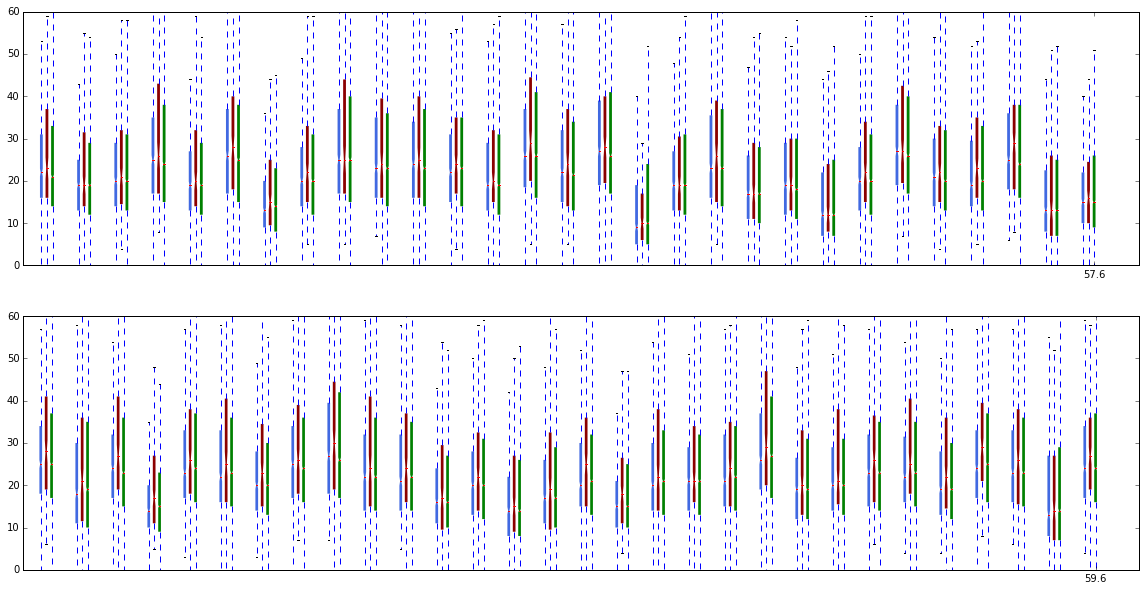

In [100]:
fig = plt.figure(figsize = (20,10))

sex_ID = 1
for sex in XYpop_dict:
    fig.add_subplot(2,1,sex_ID)
    print sex
    position = 1
    for sample in XYpop_dict[sex]:
        
        box = plt.boxplot(XYpop_dict[sex][sample], positions = [position], patch_artist=True, notch= True, showfliers=False)
        
        for abox in box['boxes']:
            abox.set_facecolor("royalblue")
            abox.set_edgecolor("none")
            
        box2 = plt.boxplot(ZWlike_pop_dict[sex][sample], positions = [position+0.3], patch_artist=True, notch= True, showfliers=False)
        for abox in box2['boxes']:
            abox.set_facecolor("darkred")
            abox.set_edgecolor("none")
            
        box3 = plt.boxplot(Auto_pop_dict[sex][sample], positions = [position+0.6], patch_artist=True, notch= True, showfliers=False)
        for abox in box3['boxes']:
            abox.set_facecolor("green")
            abox.set_edgecolor("none")

            
        position += 2
    sex_ID += 1

    plt.xlim(0, position + 1)
    plt.ylim(0, 60)

plt.savefig("/home/djeffrie/Data/RADseq/Ritalica3/Stacks/Populations_all/XY_ZW_Auto_coverages_per_sample.pdf")
plt.show()

#### Will more thoroughly check the coverage - comparing coverages of each locus (normalised by sample average coverage) across males and females. 

In [103]:
import numpy as np

mean_auto_dict = {}


for sex in Auto_pop_dict:
    mean_auto_dict[sex] = {}
    for sample in Auto_pop_dict[sex]:
        mean_auto_dict[sex][sample] = np.mean(Auto_pop_dict[sex][sample])

print mean_auto_dict

{'M': {'L50': 28.151058823529411, 'L51': 24.878823529411765, 'L52': 25.930588235294117, 'L19': 32.168705882352938, 'L56': 24.563294117647057, 'L42': 25.653882352941178, 'L14': 18.934352941176471, 'L59': 25.758352941176472, 'L17': 33.371529411764705, 'L41': 21.504000000000001, 'L74': 30.827529411764704, 'L13': 30.321176470588235, 'L40': 26.093411764705884, 'L21': 28.239058823529412, 'L72': 34.107764705882353, 'L25': 21.862352941176471, 'L24': 27.047058823529412, 'L73': 30.646823529411765, 'L65': 23.385411764705882, 'L64': 32.024235294117645, 'L67': 30.020235294117647, 'L66': 25.948470588235296, 'L60': 34.224470588235292, 'L44': 26.879529411764707, 'L48': 27.754823529411766, 'L58': 34.601647058823531, 'L37': 31.877882352941178, 'L33': 22.701647058823529, 'L30': 21.29435294117647}, 'F': {'L53': 32.622352941176473, 'L18': 29.125176470588237, 'L55': 30.533176470588234, 'L15': 19.52564705882353, 'L16': 31.457176470588234, 'L71': 30.26235294117647, 'L54': 25.557882352941178, 'L45': 29.4400000

In [106]:
for locus in ZWset:
    if "_" in locus:
        print locus

22341_2077695
72279_6721922
19229_1788222
99676_9269829
11642_1082659
19458_1809557
26298_2445692
67157_6245588
31258_2906991
19458_1809553
26298_2445696
75316_7004328
46158_4292676
99315_9236289
86609_8054555
14080_1309404
69241_6439391
95616_8892277
30774_2861932
98470_9157649
83372_7753585
83763_7789891
63591_5913941
100762_9370813
19754_1837077
42551_3957221
99909_9291529
88169_8199694
12546_1166762
36563_3400347
22979_2136994
83416_7757616
35537_3304906
20527_1908982
19268_1791899
27970_2601168
10050_934632
31258_2906916
50776_4722122
38450_3575836
35758_3325494
80926_7526066
27353_2543784
8129_755956
62004_5766322
88361_8217543
35758_3325412
49630_4615568
49974_4647541
32626_3034147
51327_4773399
7456_693391
59100_5496239
95215_8854964
70865_6590374
70865_6590375
18930_1760427
63163_5874088
92578_8609699
76285_7094436
96057_8933290
6281_584075
96619_8985509
19229_1788267
49602_4612909
44312_4120962
54947_5110034
70062_6515756
10652_990636
35181_3271768
16356_1521098
14455_1344260

In [153]:
import vcf

norm_ZWlike_locus_coverages_by_sex = {}
norm_ZWlike_locus_coverages_by_sex["M"] = []
norm_ZWlike_locus_coverages_by_sex["F"] = []

norm_XYlike_locus_coverages_by_sex = {}
norm_XYlike_locus_coverages_by_sex["M"] = []
norm_XYlike_locus_coverages_by_sex["F"] = []

norm_Auto_locus_coverages_by_sex = {}
norm_Auto_locus_coverages_by_sex["M"] = []
norm_Auto_locus_coverages_by_sex["F"] = []


myvcf = vcf.Reader(open("/home/djeffrie/Data/RADseq/Ritalica3/Stacks/Populations_all/batch_1.vcf.altered", 'r'))


for record in myvcf:

    Loc_ID = "%s_%s" % (record.ID, record.POS)

    ## Auto loci
    if Loc_ID not in ZWset and Loc_ID not in XYset:
        sample_norm_cov_list_male = []
        sample_norm_cov_list_female = []
        for sample in record.samples:
            if sample.sample in Auto_pop_dict["M"]: ## if sample is male
                if sample['GT'] != None:
                    sample_norm_cov_list_male.append(sample['DP']/mean_auto_dict["M"][sample.sample])
            elif sample.sample in Auto_pop_dict["F"]: ## if sample is female
                if sample['GT'] != None:
                    sample_norm_cov_list_female.append(sample['DP']/mean_auto_dict["F"][sample.sample])

        norm_Auto_locus_coverages_by_sex["M"].append(np.mean(sample_norm_cov_list_male))
        norm_Auto_locus_coverages_by_sex["F"].append(np.mean(sample_norm_cov_list_female))

    elif Loc_ID in XYset:
        sample_norm_cov_list_male = []
        sample_norm_cov_list_female = []
        for sample in record.samples:
            if sample.sample in Auto_pop_dict["M"]: ## if sample is male
                if sample['GT'] != None:
                    sample_norm_cov_list_male.append(sample['DP']/mean_auto_dict["M"][sample.sample])
            elif sample.sample in Auto_pop_dict["F"]: ## if sample is female
                if sample['GT'] != None:
                    sample_norm_cov_list_female.append(sample['DP']/mean_auto_dict["F"][sample.sample])

        norm_XYlike_locus_coverages_by_sex["M"].append(np.mean(sample_norm_cov_list_male))
        norm_XYlike_locus_coverages_by_sex["F"].append(np.mean(sample_norm_cov_list_female))

    elif Loc_ID in ZWset:
        sample_norm_cov_list_male = []
        sample_norm_cov_list_female = []
        for sample in record.samples:
            if sample.sample in Auto_pop_dict["M"]: ## if sample is male
                if sample['GT'] != None:
                    sample_norm_cov_list_male.append(sample['DP']/mean_auto_dict["M"][sample.sample])
            elif sample.sample in Auto_pop_dict["F"]: ## if sample is female
                if sample['GT'] != None:
                    sample_norm_cov_list_female.append(sample['DP']/mean_auto_dict["F"][sample.sample])

        norm_ZWlike_locus_coverages_by_sex["M"].append(np.mean(sample_norm_cov_list_male))
        norm_ZWlike_locus_coverages_by_sex["F"].append(np.mean(sample_norm_cov_list_female))


In [161]:
print "Auto Male = ", np.mean(norm_Auto_locus_coverages_by_sex["F"])
print "Auto Female = ", np.mean(norm_Auto_locus_coverages_by_sex["M"])
print "Auto Male vs Female ratio = ", np.mean(norm_Auto_locus_coverages_by_sex["M"])/np.mean(norm_Auto_locus_coverages_by_sex["F"])

print "XY Male = ", np.mean(norm_XYlike_locus_coverages_by_sex["F"])
print "XY Female = ", np.mean(norm_XYlike_locus_coverages_by_sex["M"])
print "XY Male vs Female ratio = ", np.mean(norm_XYlike_locus_coverages_by_sex["M"])/np.mean(norm_XYlike_locus_coverages_by_sex["F"])

print "ZW Male = ", np.mean(norm_ZWlike_locus_coverages_by_sex["F"])
print "ZW Female = ", np.mean(norm_ZWlike_locus_coverages_by_sex["M"])
print "ZW Male vs Female ratio = ", np.mean(norm_ZWlike_locus_coverages_by_sex["M"])/np.mean(norm_ZWlike_locus_coverages_by_sex["F"])

#print "XY-like = ", np.mean(norm_XYlike_locus_coverages_by_sex.values())
#print "ZW-like = ", np.mean(norm_Auto_locus_coverages_by_sex.values())

Auto Male =  1.0713895723
Auto Female =  1.07547665847
Auto Male vs Female ratio =  1.00381475262
XY Male =  0.843229915191
XY Female =  0.88648188334
XY Male vs Female ratio =  1.05129320885
ZW Male =  1.08870535007
ZW Female =  1.02907632945
ZW Male vs Female ratio =  0.945229422613


### # So it doesn't look like there's any major difference between males and females here, suggesting there isn't any hemizygosity, or indeed copy number difference in general. 


## So where do they map??

### XY-like markers

####Script for blasting to Rana temporaria genome:

blastn -query Putative_XYlinked_makers.fa -db /home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2-blastn-db -outfmt 5 -out Rital_XYs_Rtemp.xml -num_threads 7

In [6]:
blastouts = "/home/djeffrie/Data/RADseq/Ritalica3/Stacks/Rital_XYs_Rtemp.xml"
Rtemp_fasta = "/home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2.fa"
best_hit_crit = 1e-5
Eval_threshold = 1e-20
Window = 4000

MISC.BlastParseExtra(blastouts,Rtemp_fasta , best_hit_crit, Eval_threshold,Window)

Number of multi-alingments kept: 188
Number of unique alingments kept: 159
Getting subject scaffold segments from /home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2.fa . . . 
347 sequence scaffold segments are in /home/djeffrie/Data/RADseq/Ritalica3/Stacks/blast_4000_chunks.fa


{u'X_linkedLocusID_100965_Ylinked_tags': {'Evalue': 1.00534e-36,
  'Hit_end_coord': 3751,
  'Hit_start_coord': 3841,
  'Ref_hit_id': 'scaffold60927.1'},
 u'X_linkedLocusID_100967_Ylinked_tags': {'Evalue': 3.61586e-36,
  'Hit_end_coord': 32983,
  'Hit_start_coord': 32891,
  'Ref_hit_id': 'scaffold66411.1'},
 u'X_linkedLocusID_10250_953214_Xlinked_het_Xlinked_freq': {'Evalue': 6.13682e-24,
  'Hit_end_coord': 24465,
  'Hit_start_coord': 24401,
  'Ref_hit_id': 'scaffold15984.1'},
 u'X_linkedLocusID_10331_960710_Xlinked_het_Xlinked_freq': {'Evalue': 3.66738e-26,
  'Hit_end_coord': 48771,
  'Hit_start_coord': 48860,
  'Ref_hit_id': 'scaffold5078.1'},
 u'X_linkedLocusID_10444_971256_Xlinked_het_Xlinked_freq': {'Evalue': 2.17618e-33,
  'Hit_end_coord': 73307,
  'Hit_start_coord': 73213,
  'Ref_hit_id': 'scaffold2770.1'},
 u'X_linkedLocusID_10448_Ylinked_tags': {'Evalue': 1.68229e-34,
  'Hit_end_coord': 9150,
  'Hit_start_coord': 9242,
  'Ref_hit_id': 'scaffold14328.1'},
 u'X_linkedLocusID_1048

####Script for blasting to Nanorana parkerii genome:

blastn -query Rital_to_Rtemp_chunks_4kb.fa -db ../../STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_blast_db -outfmt 7 -out Rital_Rtemp_Nano_blast.xml -num_threads 7

In [8]:
blastouts = "/home/djeffrie/Data/RADseq/Ritalica3/Stacks/Rital_Rtemp_Nano_blast.xml"
Nano_fasta = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_parkeri.genome.v2.fasta"
best_hit_crit = 1e-5
Eval_threshold = 1e-20
Window = 4000

records = MISC.BlastParseExtra(blastouts,Nano_fasta , best_hit_crit, Eval_threshold,Window)

Number of multi-alingments kept: 161
Number of unique alingments kept: 14
Getting subject scaffold segments from /home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_parkeri.genome.v2.fasta . . . 
142 sequence scaffold segments are in /home/djeffrie/Data/RADseq/Ritalica3/Stacks/blast_4000_chunks.fa


####Script for blasting to Xenopus genome:

blastn -query Rital_to_Rtemp_to_Nano_chunks_4kb.fa -db /home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xenoupus_blastdb -outfmt 5 -out Rital_Rtemp_Nano_blast.xml -num_threads 7

In [58]:
blastouts = "/home/djeffrie/Data/RADseq/Ritalica3/Stacks/Rital_Rtemp_Nano_Xen_blast.xml"
Xen_fasta = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xtropicalis.v9.repeatMasked.fa"
best_hit_crit = 1e-5
Eval_threshold = 1e-20
Window = 4000

Xen_records = MISC.BlastParseExtra(blastouts,Xen_fasta , best_hit_crit, Eval_threshold,Window)

Number of multi-alingments kept: 12
Number of unique alingments kept: 21
Getting subject scaffold segments from /home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xtropicalis.v9.repeatMasked.fa . . . 
30 sequence scaffold segments are in /home/djeffrie/Data/RADseq/Ritalica3/Stacks/blast_4000_chunks.fa


In [59]:
from collections import Counter 
Xen_hits = []
for i in Xen_records:
    Xen_hits.append(Xen_records[i]["Ref_hit_id"])

print Counter(Xen_hits)
                      


Counter({'Chr01': 24, 'Chr04': 2, 'Chr07': 2, 'Chr02': 1, 'Chr09': 1})


### So 24 hits on Ch01, looks like a pretty confident consensus


### Now for the ZW-like tags

####Script for blasting to Rana temporaria genome:

blastn -query Putative_ZWlinked_makers.fa -db /home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2-blastn-db -outfmt 5 -out Rital_XYs_Rtemp.xml -num_threads 7

In [49]:
blastouts = "/home/djeffrie/Data/RADseq/Ritalica3/Stacks/Rital_ZWs_Rtemp.xml"
Rtemp_fasta = "/home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2.fa"
best_hit_crit = 1e-5
Eval_threshold = 1e-20
Window = 8000

Rtemp_records = MISC.BlastParseExtra(blastouts,Rtemp_fasta , best_hit_crit, Eval_threshold,Window)

Number of multi-alingments kept: 32
Number of unique alingments kept: 38
Getting subject scaffold segments from /home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2.fa . . . 
70 sequence scaffold segments are in /home/djeffrie/Data/RADseq/Ritalica3/Stacks/blast_8000_chunks.fa


####Script for blasting to Nanorana parkerii genome:

blastn -query Rital_to_Rtemp_chunks_2kb.fa -db ../../STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_blast_db -outfmt 5 -out Rital_XWs_2kb_Rtemp_Nano_blast.xml -num_threads 7

blastn -query Rital_to_Rtemp_chunks_4kb.fa -db ../../STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_blast_db -outfmt 5 -out Rital_Rtemp_Nano_blast.xml -num_threads 7

blastn -query Rital_to_Rtemp_chunks_6kb.fa -db ../../STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_blast_db -outfmt 5 -out Rital_ZW_6kb_Rtemp_Nano_blast.xml -num_threads 7

blastn -query Rital_to_Rtemp_chunks_8kb.fa -db ../../STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_blast_db -outfmt 5 -out Rital_ZW_8kb_Rtemp_Nano_blast.xml -num_threads 7


In [50]:
blastouts = "/home/djeffrie/Data/RADseq/Ritalica3/Stacks/Rital_ZW_8kb_Rtemp_Nano_blast.xml"
Nano_fasta = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_parkeri.genome.v2.fasta"
best_hit_crit = 1e-5
Eval_threshold = 1e-20
Window = 8000

records = MISC.BlastParseExtra(blastouts,Nano_fasta , best_hit_crit, Eval_threshold,Window)

Number of multi-alingments kept: 38
Number of unique alingments kept: 0
Getting subject scaffold segments from /home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_parkeri.genome.v2.fasta . . . 
31 sequence scaffold segments are in /home/djeffrie/Data/RADseq/Ritalica3/Stacks/blast_8000_chunks.fa


In [ ]:
####Script for blasting to Xenopus genome:

blastn -query Rital_ZWs_to_Rtemp_to_Nano_chunks_2kb.fa -db /home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xenoupus_blastdb -outfmt 5 -out Rital_Rtemp_Nano_blast.xml -num_threads 7

In [27]:
blastouts = "/home/djeffrie/Data/RADseq/Ritalica3/Stacks/Rital_ZWs_Rtemp_2kbs_Nano_2kbs_Xen_blast.xml"
Xen_fasta = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xtropicalis.v9.repeatMasked.fa"
best_hit_crit = 1e-5
Eval_threshold = 1e-20
Window = 4000

Xen_records2kb = MISC.BlastParseExtra(blastouts,Xen_fasta , best_hit_crit, Eval_threshold,Window)

Number of multi-alingments kept: 0
Number of unique alingments kept: 1
Getting subject scaffold segments from /home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_parkeri.genome.v2.fasta . . . 
0 sequence scaffold segments are in /home/djeffrie/Data/RADseq/Ritalica3/Stacks/blast_4000_chunks.fa


In [30]:
blastouts = "/home/djeffrie/Data/RADseq/Ritalica3/Stacks/Rital_ZWs_Rtemp_Nano_Xen_blast.xml"
Xen_fasta = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xtropicalis.v9.repeatMasked.fa"
best_hit_crit = 1e-5
Eval_threshold = 1e-20
Window = 4000

Xen_records4kb = MISC.BlastParseExtra(blastouts,Xen_fasta , best_hit_crit, Eval_threshold,Window)

Number of multi-alingments kept: 1
Number of unique alingments kept: 2
Getting subject scaffold segments from /home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_parkeri.genome.v2.fasta . . . 
0 sequence scaffold segments are in /home/djeffrie/Data/RADseq/Ritalica3/Stacks/blast_4000_chunks.fa


In [40]:
blastouts = "/home/djeffrie/Data/RADseq/Ritalica3/Stacks/Rital_ZWs_Rtemp_Nano_blast_6kb.xml"
Xen_fasta = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xtropicalis.v9.repeatMasked.fa"
best_hit_crit = 1e-5
Eval_threshold = 1e-20
Window = 4000

Xen_records6kb = MISC.BlastParseExtra(blastouts,Xen_fasta , best_hit_crit, Eval_threshold,Window)

Number of multi-alingments kept: 4
Number of unique alingments kept: 5
Getting subject scaffold segments from /home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_parkeri.genome.v2.fasta . . . 
0 sequence scaffold segments are in /home/djeffrie/Data/RADseq/Ritalica3/Stacks/blast_4000_chunks.fa


In [54]:
blastouts = "/home/djeffrie/Data/RADseq/Ritalica3/Stacks/Rital_ZWs_Rtemp_Nano_blast_8kb.xml"
Xen_fasta = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xtropicalis.v9.repeatMasked.fa"
best_hit_crit = 1e-5
Eval_threshold = 1e-20
Window = 4000

Xen_records8kb = MISC.BlastParseExtra(blastouts,Xen_fasta , best_hit_crit, Eval_threshold,Window)

Number of multi-alingments kept: 8
Number of unique alingments kept: 4
Getting subject scaffold segments from /home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xtropicalis.v9.repeatMasked.fa . . . 
11 sequence scaffold segments are in /home/djeffrie/Data/RADseq/Ritalica3/Stacks/blast_4000_chunks.fa


In [45]:
from collections import Counter 
Xen_hits = []
for i in Xen_records:
    Xen_hits.append(Xen_records2kb[i]["Ref_hit_id"])
    print i, Xen_records2kb[i]["Ref_hit_id"]

print "N hits on Chr01:", Counter(Xen_hits)["Chr01"]

scaffold541 Chr01
N hits on Chr01: 1


In [47]:
from collections import Counter 
Xen_hits = []
for i in Xen_records4kb:
    Xen_hits.append(Xen_records4kb[i]["Ref_hit_id"])
    print i, Xen_records4kb[i]["Ref_hit_id"]

print "N hits on Chr01:", Counter(Xen_hits)["Chr01"]

 scaffold124 scaffold_51
scaffold441 Chr02
scaffold541 Chr01
N hits on Chr01: 1


In [48]:
from collections import Counter 
Xen_hits = []
for i in Xen_records6kb:
    Xen_hits.append(Xen_records6kb[i]["Ref_hit_id"])
    print i, Xen_records6kb[i]["Ref_hit_id"]

print "N hits on Chr01:", Counter(Xen_hits)["Chr01"]

scaffold256 Chr06
scaffold244 Chr01
scaffold172 Chr05
scaffold619 Chr01
scaffold2222 Chr01
scaffold124 Chr03
scaffold441 Chr02
scaffold541 Chr01
N hits on Chr01: 4


In [55]:
from collections import Counter 
Xen_hits = []
for i in Xen_records8kb:
    Xen_hits.append(Xen_records8kb[i]["Ref_hit_id"])
    print i, Xen_records6kb[i]["Ref_hit_id"]

print "N hits on Chr01:", Counter(Xen_hits)["Chr01"]

scaffold160 Chr01
scaffold244 Chr01
scaffold1371 Chr01
scaffold172 Chr05
scaffold310 Chr01
scaffold1674 Chr01
scaffold2222 Chr01
scaffold619 Chr01
scaffold124 Chr03
scaffold441 Chr02
scaffold541 Chr01
N hits on Chr01: 8


In [56]:
Xen_records8kb

{u'scaffold124': {'Evalue': 9.49966e-98,
  'Hit_end_coord': 80446284,
  'Hit_start_coord': 80447134,
  'Ref_hit_id': 'Chr03'},
 u'scaffold1371': {'Evalue': 2.91292e-23,
  'Hit_end_coord': 127196698,
  'Hit_start_coord': 127196830,
  'Ref_hit_id': 'Chr01'},
 u'scaffold160': {'Evalue': 9.30473e-43,
  'Hit_end_coord': 105581313,
  'Hit_start_coord': 105581429,
  'Ref_hit_id': 'Chr01'},
 u'scaffold1674': {'Evalue': 7.6207e-49,
  'Hit_end_coord': 122794994,
  'Hit_start_coord': 122795227,
  'Ref_hit_id': 'Chr01'},
 u'scaffold172': {'Evalue': 2.48973e-88,
  'Hit_end_coord': 6455685,
  'Hit_start_coord': 6455131,
  'Ref_hit_id': 'Chr05'},
 u'scaffold2222': {'Evalue': 0.0,
  'Hit_end_coord': 171284321,
  'Hit_start_coord': 171283890,
  'Ref_hit_id': 'Chr01'},
 u'scaffold244': {'Evalue': 3.2294e-77,
  'Hit_end_coord': 85736565,
  'Hit_start_coord': 85736293,
  'Ref_hit_id': 'Chr01'},
 u'scaffold310': {'Evalue': 4.47463e-41,
  'Hit_end_coord': 90725248,
  'Hit_start_coord': 90725077,
  'Ref_hit_

### So the answer is - both the XYs and the ZWs seem to map onto chromosome 1 !!


### Is there any pattern in where the tags map to the genome?

[23120110, 37325648, 55705594, 58634886, 66620088, 67846115, 79870653, 80663625, 87133345, 107816223, 112084410, 123632800, 132492947, 133023812, 133618797, 135072270, 140340035, 141582075, 142001936, 144428634, 168800668, 170608388, 180358001, 184950340]


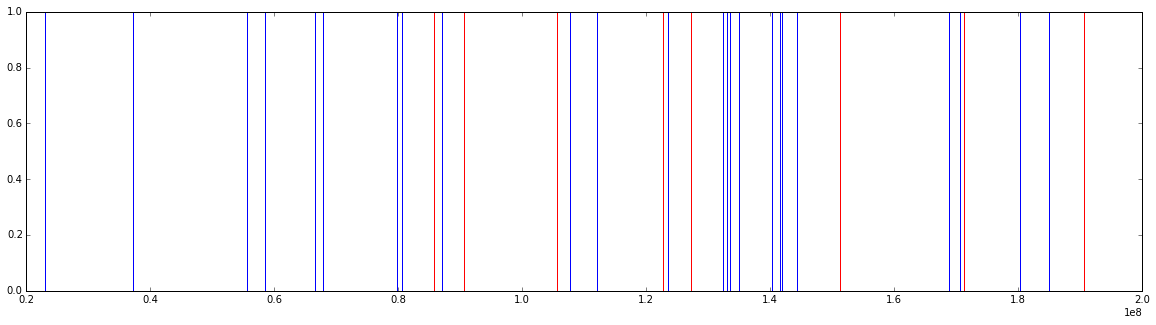

In [91]:
XY_coordinates = []
ZW_coordinates = []

for scaff in Xen_records:
    if Xen_records[scaff]["Ref_hit_id"] == "Chr01":
        XY_coordinates.append(int(Xen_records[scaff]["Hit_start_coord"]))

        
for scaff in Xen_records8kb:
    if Xen_records8kb[scaff]["Ref_hit_id"] == "Chr01":
        ZW_coordinates.append(int(Xen_records8kb[scaff]["Hit_start_coord"]))

        
print sorted(XY_coordinates)


plt.figure(figsize=(20,5))
plt.bar(sorted(XY_coordinates), [1]*(len(XY_coordinates)), color = "blue", edgecolor = "blue")
plt.bar(sorted(ZW_coordinates), [1]*(len(ZW_coordinates)), color = "red", edgecolor = "red")

plt.show()


Doesn't seem to be any obvious pattern, 

In [94]:
 (max(XY_coordinates) - min(XY_coordinates))/1000000

161.83023

In [95]:
(max(ZW_coordinates) - min(ZW_coordinates))/1000000

104.929157

### Checking the XY vs ZW coverages again. 


##### Using SNP frequency approach #### 

Number of loci = 4250
Number of samples = 59
Number of loci with too few samples = 573
Number of loci with low MAF = 0
Number of loci with enough data = 3676
Number of putative X linked snps = 621
Number of putative X linked tags = 621
Number of putative Z linked markers = 140
Number of putative Z linked tags = 140


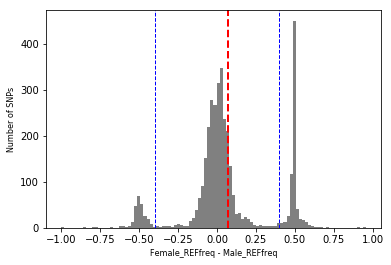


***DONE!***


##### Using SNP heterozygosity approach #####
 
Number of loci = 4250
Number of samples = 59
Number of loci with too few samples = 573
Number of loci with low MAF = 0
Number of loci with enough data = 3676
Number of putative X linked snps = 639
Number of putative X linked tags = 639
Number of putative Z linked markers = 149
Number of putative Z linked tags = 149

 ### DONE! ### 


##### Using Sex specific tag approach ##### 


SUMMARY:
Number of females: 30
Number of males: 29
Number of Putative Y linked tags: 517
Number of Putative W linked tags: 97

 ### DONE! ###

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Ritalica3_ext

 ## After merging tags accross methods ## 

Final number of XY tags = 1157
Final number of ZW tags = 249


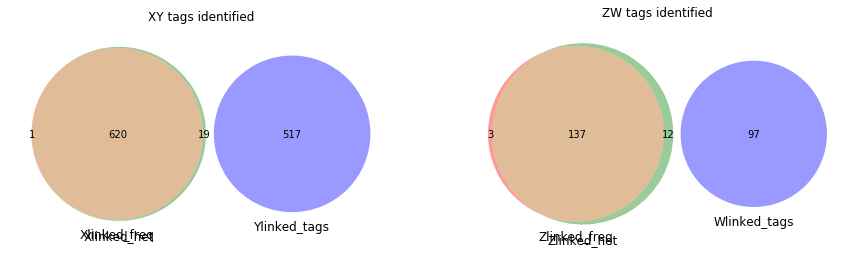

In [3]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Ritalica3_ext/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Ritalica3_ext/Populations_all/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Ritalica3_ext/Sex_ID_info.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 7 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 0.9 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 0.9 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 7 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.

XYset, ZWset = MISC.Super_SLM_finder(Parameter_dict, "111")

In [4]:
## get just catalof IDs.
ZWs = [i.split("_")[0] for i in ZWset]
XYs = [i.split("_")[0] for i in XYset]

In [5]:
import vcf

myvcf = vcf.Reader(open("/home/djeffrie/Data/RADseq/Ritalica3_ext/Populations_all/batch_1.vcf.altered", 'r'))

ZW_records = {}
XY_records = {}

for record in myvcf:
    if record.ID in ZWs:
        ZW_records[record.ID] = record
        print "ZW", record
    elif record.ID in XYs:
        XY_records[record.ID] = record
        print "XY", record

XY Record(CHROM=un, POS=30728, REF=T, ALT=[C])
XY Record(CHROM=un, POS=30744, REF=G, ALT=[A])
XY Record(CHROM=un, POS=30749, REF=C, ALT=[T])
XY Record(CHROM=un, POS=30773, REF=G, ALT=[T])
XY Record(CHROM=un, POS=30774, REF=T, ALT=[G])
XY Record(CHROM=un, POS=276276, REF=G, ALT=[T])
XY Record(CHROM=un, POS=276285, REF=C, ALT=[T])
XY Record(CHROM=un, POS=307562, REF=C, ALT=[T])
XY Record(CHROM=un, POS=328088, REF=G, ALT=[A])
XY Record(CHROM=un, POS=342851, REF=G, ALT=[A])
XY Record(CHROM=un, POS=343143, REF=A, ALT=[G])
XY Record(CHROM=un, POS=345643, REF=C, ALT=[T])
XY Record(CHROM=un, POS=345645, REF=C, ALT=[T])
XY Record(CHROM=un, POS=406118, REF=T, ALT=[C])
XY Record(CHROM=un, POS=436355, REF=T, ALT=[C])
XY Record(CHROM=un, POS=459066, REF=G, ALT=[C])
ZW Record(CHROM=un, POS=475694, REF=A, ALT=[G])
XY Record(CHROM=un, POS=476287, REF=G, ALT=[C])
XY Record(CHROM=un, POS=492090, REF=T, ALT=[G])
XY Record(CHROM=un, POS=503819, REF=T, ALT=[G])
XY Record(CHROM=un, POS=519333, REF=T, ALT=[G

In [6]:
## Now get male and female data

sex_info = open("/home/djeffrie/Data/RADseq/Ritalica3_ext/Sex_ID_info.txt", 'r').readlines()

sex_info_dict = {}

for line in sex_info:
    sample = line.split()[0]
    sex = line.split()[1]
    
    sex_info_dict[sample] = sex
        

In [7]:
## So now I can go get the coverages for males and females
import numpy as np

myvcf = vcf.Reader(open("/home/djeffrie/Data/RADseq/Ritalica3_ext/Populations_all/batch_1.vcf.altered", 'r'))

## ZW first
ZWmale_covs = []
ZWfemale_covs = []

for record in myvcf:
    if record.ID in ZWs:
        Male_record_list = []
        Female_record_list = []
        
        for sample in record.samples:
            if sex_info_dict[sample.sample] == "M":
                if sample["DP"] > 0:
                    Male_record_list.append(sample["DP"])
            elif sex_info_dict[sample.sample] == "F":
                if sample["DP"] > 0:
                    Female_record_list.append(sample["DP"])
        
        male_mean = np.mean(Male_record_list)
        female_mean = np.mean(Female_record_list)
        
        ZWmale_covs.append(male_mean)
        ZWfemale_covs.append(female_mean)
    

## XY 

myvcf = vcf.Reader(open("/home/djeffrie/Data/RADseq/Ritalica3_ext/Populations_all/batch_1.vcf.altered", 'r'))

XYmale_covs = []
XYfemale_covs = []

for record in myvcf:
    if record.ID in XYs:
        Male_record_list = []
        Female_record_list = []
        
        for sample in record.samples:
            if sex_info_dict[sample.sample] == "M":
                if sample["DP"] > 0:
                    Male_record_list.append(sample["DP"])
            elif sex_info_dict[sample.sample] == "F":
                if sample["DP"] > 0:
                    Female_record_list.append(sample["DP"])
        
        male_mean = np.mean(Male_record_list)
        female_mean = np.mean(Female_record_list)
        
        XYmale_covs.append(male_mean)
        XYfemale_covs.append(female_mean)

print "ZW males", np.mean(ZWmale_covs)
print "ZW females", np.mean(ZWfemale_covs)

print "XY males", np.mean(XYmale_covs)
print "XY females", np.mean(XYfemale_covs)



ZW males 29.6415818718
ZW females 32.4680728511
XY males 24.4702435253
XY females 23.9211361868


ZW-like compared between males and females
t = -1.04445494149
p = 0.594069663838
df = 332


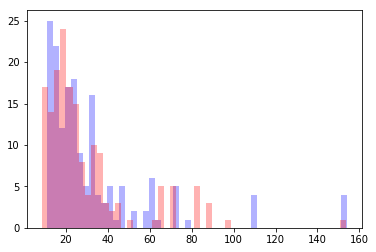

In [10]:
## Quick t-test on this
from scipy import stats

print "ZW-like compared between males and females"
t2, p2 = stats.ttest_ind(ZWmale_covs, ZWfemale_covs)
print("t = " + str(t2))
print("p = " + str(2*p2))
print "df = %s" % (len(ZWmale_covs)+len(ZWfemale_covs)-2)

from matplotlib import pyplot as plt

plt.hist(ZWfemale_covs, color = "blue", alpha = 0.3, bins = 50)
plt.hist(ZWmale_covs, color = "red", alpha = 0.3,  bins = 50)
plt.show()

XY-like compared between males and females
t = 0.8029933251
p = 0.844248955227
df = 1308


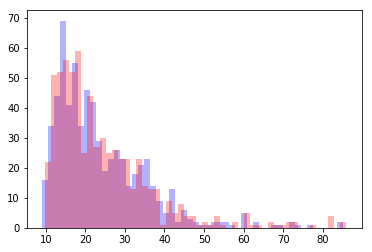

In [11]:
print "XY-like compared between males and females"
t2, p2 = stats.ttest_ind(XYmale_covs, XYfemale_covs)
print("t = " + str(t2))
print("p = " + str(2*p2))
print "df = %s" % (len(XYmale_covs)+len(XYfemale_covs)-2)

plt.hist(XYfemale_covs, color = "blue", alpha = 0.3,  bins = 50)
plt.hist(XYmale_covs, color = "red", alpha = 0.3,  bins = 50)
plt.show()